In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [9]:
# Функции сглаживания, сплита ряда данных и вычисления ошибки

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [2]:
#Загрузка данных
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [6]:
#Описание данных
data.describe(include='all').transpose().round()

#Пропусков,пропусков, отрицательных значений нет


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,145374,24,15:00:00,6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PJME_MW,145374,NaN,NaN,NaN,32079.8,6464.17,14544,27573,31421,35648.8,62009
year,145374,NaN,NaN,NaN,2009.8,4.79189,2002,2006,2010,2014,2018
month,145374,NaN,NaN,NaN,6.43598,3.43898,1,3,6,9,12
dayofmonth,145374,NaN,NaN,NaN,15.7227,8.80126,1,8,16,23,31
quarter,145374,NaN,NaN,NaN,2.48124,1.11445,1,1,2,3,4
dayofyear,145374,NaN,NaN,NaN,180.46,105.138,1,90,179,271,366
weekofyear,145374,NaN,NaN,NaN,26.2186,15.0198,1,13,26,39,53
dayofweek,145374,NaN,NaN,NaN,2.99917,1.99957,0,1,3,5,6
hour,145374,NaN,NaN,NaN,11.5011,6.92193,0,6,12,18,23


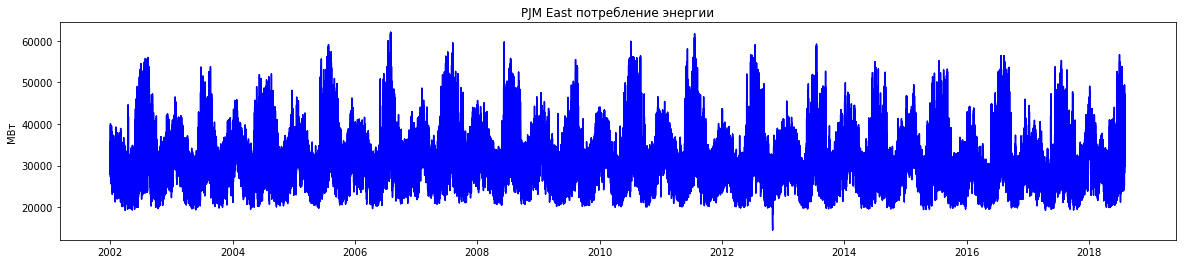

In [7]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [20]:
#Конвертируем данные в дневное потребление
d_data=data.resample('D').mean()

In [21]:
#Применим экспоненциальное сглаживание

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)

In [22]:
#Запишем результат в датафрейм + добавим признаки

df= pd.DataFrame(data_exp_1)

df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)

df.head(4)

,0,t,t1,t2
0,31080.739130,0.000000,0.000000,0.00000
1,31239.779257,31080.739130,0.000000,0.00000
2,31403.384044,31239.779257,31080.739130,0.00000
3,31518.987759,31403.384044,31239.779257,31080.73913


In [13]:
train_b, test_b = split_data_b( df, '10-10-2017')


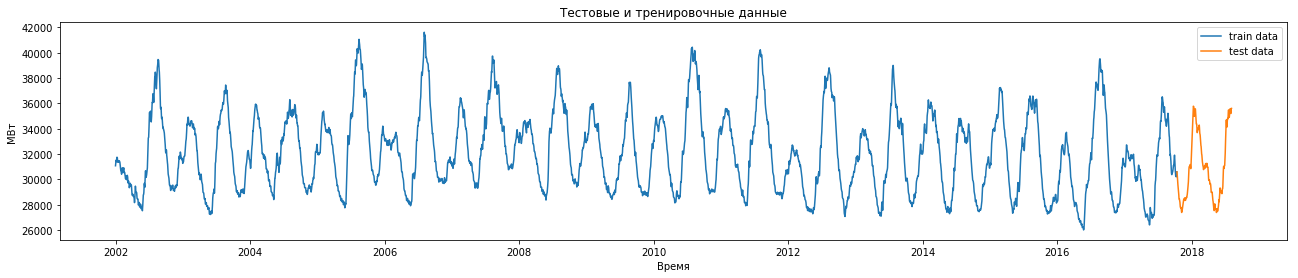

In [14]:
plt.figure( figsize=( 22, 4 ))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

### Оцените ошибку модели из п.1 .

In [27]:
#Запишем в функцию постороения прогноза в зависимости от глубины

def h_boost(h,train_b=train_b, test_b=test_b):
    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df.columns[0]].values[h:]
    
    model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
    model_gb.fit( X_train_b, y_train_b ) 
    X_test_pred_gb = model_gb.predict(X_test_b)
    
    
    plt.figure( figsize=( 22, 4 ))

    plt.xlabel('Время')
    plt.ylabel('МВт')
    plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
    plt.plot(test_b.index[h:],y_test_b, label='test data')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
    print(f'Для глубины прогноза {h}')
    print(f'ошибка градиентного бустинга : {er_g:.3f} %')
    

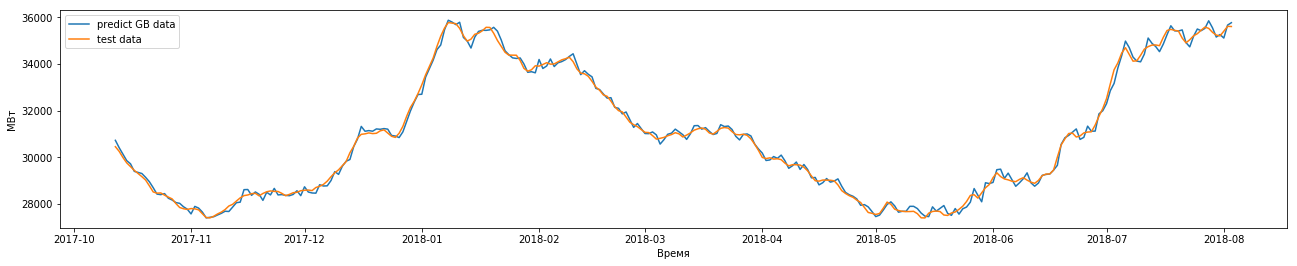

Для глубины прогноза 1
ошибка градиентного бустинга : 0.418 %


In [29]:
h_boost(1)

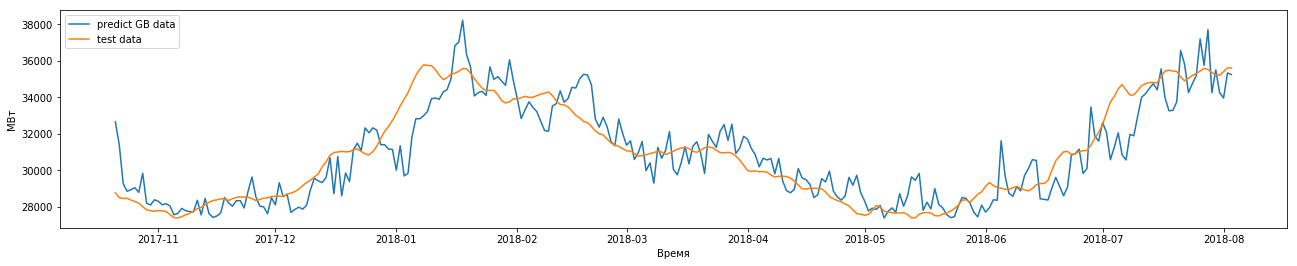

Для глубины прогноза 10
ошибка градиентного бустинга : 2.975 %


In [28]:
h_boost(10)

### Сделайте вывод о том, как изменилась ошибка модели по значениям h.

С увеличением глубины прогноза, ошибка значительно увеличивается.